# Quantitative Finance Model using Donadio and Ghosh Learn Algorithmic Trading Chapter 2 Seasonality Examples
### David Lowe
### August 9, 2022

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This script aims to replicate the seasonality example found in chapter two of the book Learn Algorithmic Trading by Sebastien Donadio and Sourav Ghosh. The script seeks to validate the Python environment and package requirements for running these code examples successfully. The eventual goal is to integrate various example code segments from the book into an end-to-end algorithmic trading system.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Sharadar US Equities and Fund Prices from Quandl/Nasdaq Data Link

Source and Further Discussion of the Code Examples: https://github.com/PacktPublishing/Learn-Algorithmic-Trading

# Task 1 - Prepare Environment

## 1.a) Load the required packages and modules

In [1]:
# import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
# import statistics as stats
# import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# import seaborn as sns

## 1.b) Set up the controlling parameters and functions

In [2]:
# Specify the key modeling parameters below
DATA_STORE = '../sharadar.h5'
ticker_symbol = 'GOOGL'

STDEV_WINDOW = 20 # look back period for standard derivative
MOM_WINDOW = 20 # how far to look back to find reference price to compute momentum

MODEL_START_DATE = date(2012, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2021, 12, 31)
print("Ending date for the model:", MODEL_END_DATE)

Starting date for the model: 2012-01-01
Ending date for the model: 2021-12-31


# Task 2 - Acquire and Pre-Process Data

## Instead of using pandas-datareader like in the book example, this script will use a home-grown data source.

In [3]:
with pd.HDFStore(DATA_STORE) as store:
    goog_data = (store['quandl/sharadar/sep'].loc[[ticker_symbol], ['open', 'high', 'low', 'closeadj', 'volume']])
goog_data.reset_index(level=0, inplace=True)
goog_data.sort_index(inplace=True)
goog_data = goog_data[MODEL_START_DATE:MODEL_END_DATE]
goog_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-01-03 to 2021-12-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ticker    2517 non-null   object 
 1   open      2517 non-null   float64
 2   high      2517 non-null   float64
 3   low       2517 non-null   float64
 4   closeadj  2517 non-null   float64
 5   volume    2517 non-null   float64
dtypes: float64(5), object(1)
memory usage: 137.6+ KB


# Task 3 - Build model with the STDEV indicator

## This code segment implements and visualizes standard derivatives.

In [4]:
goog_monthly_return = goog_data['closeadj'].pct_change().groupby(
    [goog_data['closeadj'].index.year,
     goog_data['closeadj'].index.month]).mean()
print(goog_monthly_return.head())

date  date
2012  1      -0.006934
      2       0.003230
      3       0.001707
      4      -0.002809
      5      -0.001710
Name: closeadj, dtype: float64


In [5]:
goog_monthly_return_list=[]
for i in range(len(goog_monthly_return)):
    goog_monthly_return_list.append({'month':goog_monthly_return.index[i][1],
                                    'monthly_return': goog_monthly_return.iloc[i]})

goog_monthly_return_list=pd.DataFrame(goog_monthly_return_list,
                                     columns=('month','monthly_return'))
print(goog_monthly_return_list.head())
print(goog_monthly_return_list.tail())

   month  monthly_return
0      1       -0.006934
1      2        0.003230
2      3        0.001707
3      4       -0.002809
4      5       -0.001710
     month  monthly_return
115      8        0.003280
116      9       -0.003694
117     10        0.005018
118     11       -0.001910
119     12        0.001011


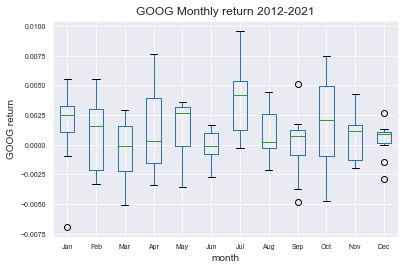

In [6]:
goog_monthly_return_list.boxplot(column='monthly_return', by='month')
ax = plt.gca()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels=['Jan','Feb','Mar','Apr','May','Jun',
        'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(labels)
ax.set_ylabel('GOOG return')
plt.tick_params(axis='both', which='major', labelsize=7)
plt.title("GOOG Monthly return 2012-2021")
plt.suptitle("")
plt.show()

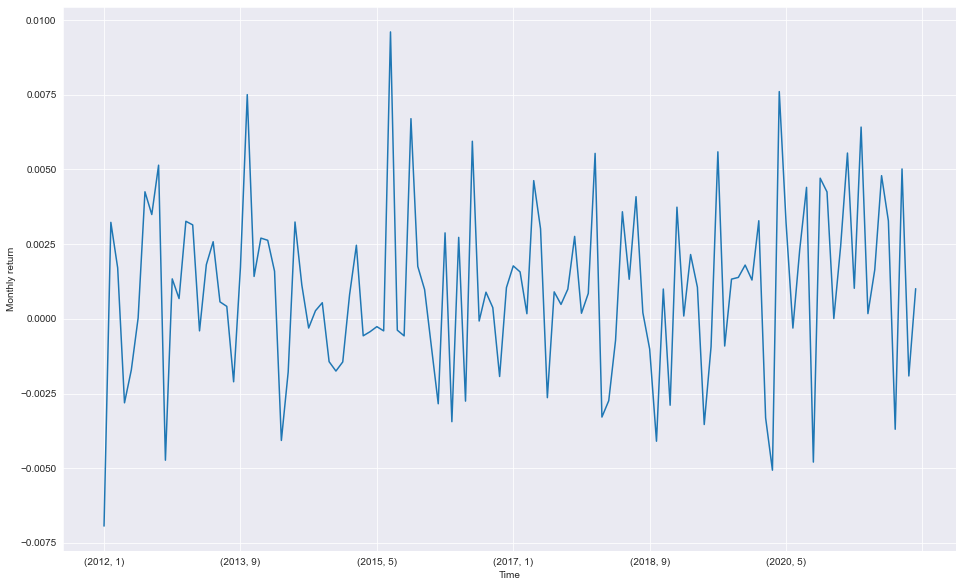

In [7]:
fig = plt.figure(figsize=(16, 10))
goog_data['closeadj'].pct_change().groupby(
    [goog_data['closeadj'].index.month])
ax1 = fig.add_subplot(111, ylabel='Monthly return')
goog_monthly_return.plot()
plt.xlabel('Time')
plt.show()

In [8]:
# Displaying rolling statistics
def plot_rolling_statistics_ts(ts, titletext,ytext, window_size=12):
    plt.figure(figsize=(16, 10))
    ts.plot(color='red', label='Original', lw=0.5)
    ts.rolling(window_size).mean().plot(
            color='blue',label='Rolling Mean')
    ts.rolling(window_size).std().plot(
            color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.ylabel(ytext)
    plt.title(titletext)
    plt.show(block=False)

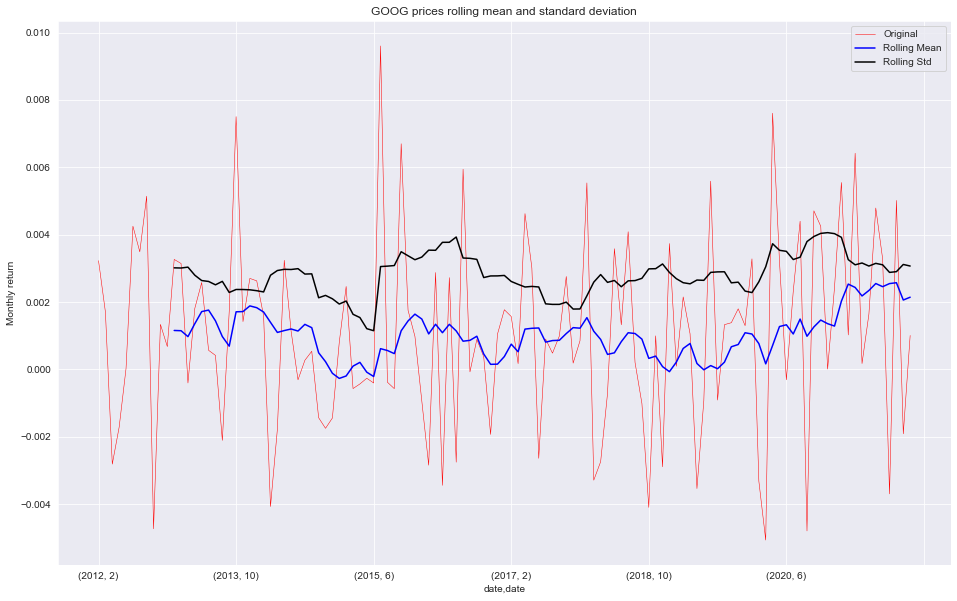

In [9]:
plot_rolling_statistics_ts(goog_monthly_return[1:],'GOOG prices rolling mean and standard deviation','Monthly return')

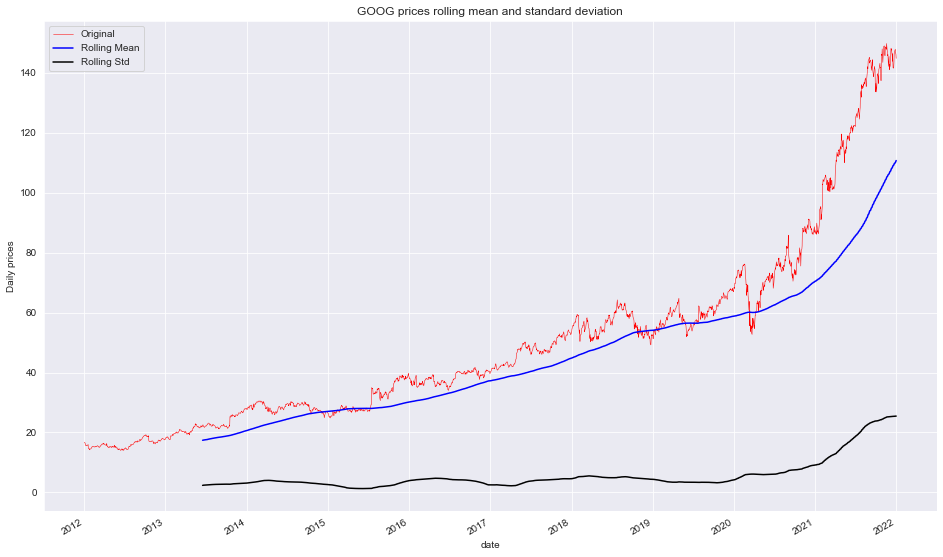

In [10]:
plot_rolling_statistics_ts(goog_data['closeadj'],'GOOG prices rolling mean and standard deviation','Daily prices',365)

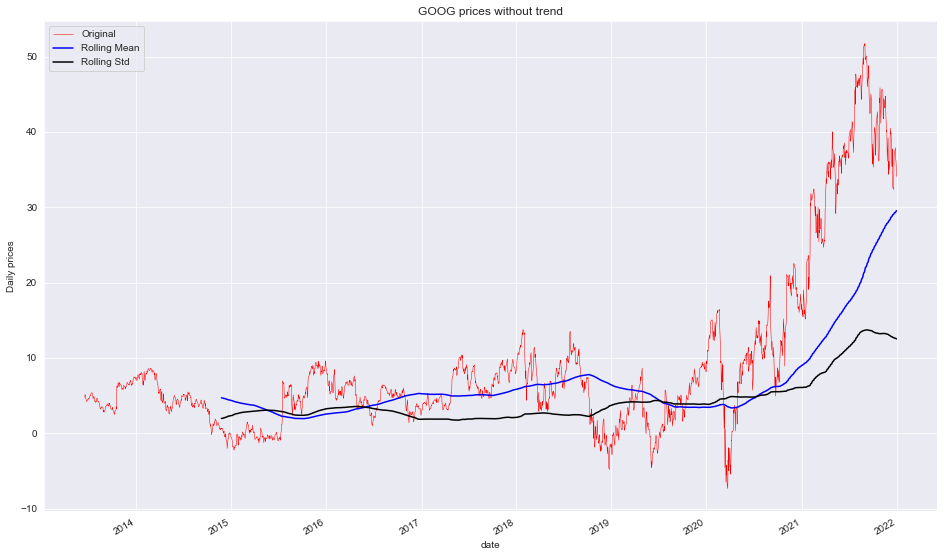

In [11]:
plot_rolling_statistics_ts(goog_data['closeadj']-goog_data['closeadj'].rolling(365).mean(),'GOOG prices without trend','Daily prices',365)

In [12]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[1:], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    print(dfoutput)

test_stationarity(goog_monthly_return[1:])

Results of Dickey-Fuller Test:
Test Statistic                -1.220864e+01
p-value                        1.177630e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.170000e+02
dtype: float64


In [13]:
test_stationarity(goog_data['closeadj'])

Results of Dickey-Fuller Test:
Test Statistic                    2.304767
p-value                           0.998958
#Lags Used                       19.000000
Number of Observations Used    2496.000000
dtype: float64


C:\Users\daine\PycharmProjects\quantfinVenv\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


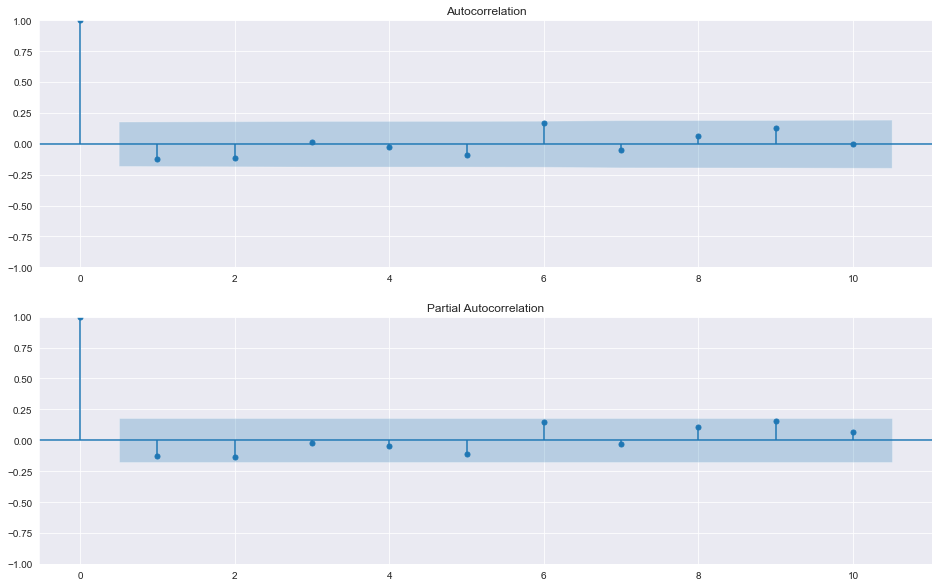

In [14]:
plt.figure(figsize=(16, 10))
plt.subplot(211)
plot_acf(goog_monthly_return[1:], ax=plt.gca(), lags=10)
plt.subplot(212)
plot_pacf(goog_monthly_return[1:], ax=plt.gca(), lags=10)
plt.show()

C:\Users\daine\PycharmProjects\quantfinVenv\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\daine\PycharmProjects\quantfinVenv\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\daine\PycharmProjects\quantfinVenv\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


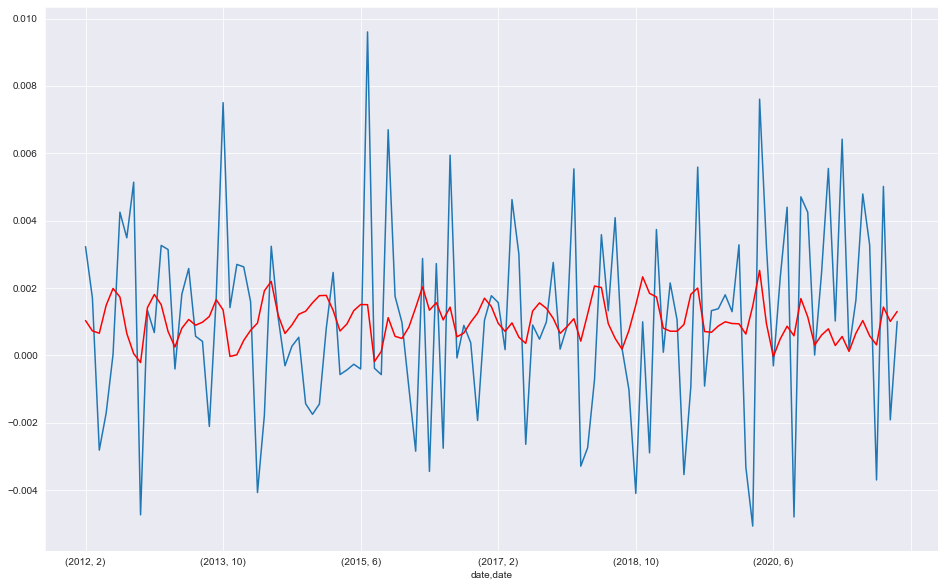

In [15]:
model = ARIMA(goog_monthly_return[1:], order=(2, 0, 2))
fitted_results = model.fit()
goog_monthly_return[1:].plot(figsize=(16, 10))
fitted_results.fittedvalues.plot(color='red')
plt.show()